In [18]:
!pip install -U langgraph langchain-openai

  Using cached langgraph-0.6.6-py3-none-any.whl.metadata (6.8 kB)
  Using cached langchain_openai-0.3.32-py3-none-any.whl.metadata (2.4 kB)
  Using cached langgraph_prebuilt-0.6.4-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.2.4-py3-none-any.whl.metadata (1.5 kB)
Using cached langgraph-0.6.6-py3-none-any.whl (153 kB)
Using cached langgraph_prebuilt-0.6.4-py3-none-any.whl (28 kB)
Using cached langgraph_sdk-0.2.4-py3-none-any.whl (53 kB)
Using cached langchain_openai-0.3.32-py3-none-any.whl (74 kB)
  Attempting uninstall: langgraph-sdk
    Found existing installation: langgraph-sdk 0.1.74
    Uninstalling langgraph-sdk-0.1.74:
      Successfully uninstalled langgraph-sdk-0.1.74
  Attempting uninstall: langchain-openai
    Found existing installation: langchain-openai 0.3.14
    Uninstalling langchain-openai-0.3.14:
      Successfully uninstalled langchain-openai-0.3.14
  Attempting uninstall: langgraph-prebuilt
    Found existing installation: langgraph-prebuilt 0.1.

In [19]:
%%capture
!pip install langgraph==0.3.34 langchain-openai==0.3.14 langchainhub==0.1.21 langchain==0.3.24 pygraphviz==1.14 langchain-community==0.3.23

In [20]:
import warnings 
warnings.filterwarnings('ignore')

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import tool
import os
import json

os.environ["TAVILY_API_KEY"] = "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"

# Initialize the Tavily search tool
search = TavilySearchResults()

@tool
def search_tool(query: str):
    """
    Search the web for information using Tavily API.

    :param query: The search query string
    :return: Search results related to the query
    """
    return search.invoke(query)

In [21]:
search_tool("What's the weather like in Tokyo today?")

[{'title': 'Tokyo weather in August 2025 - Weather25.com',
  'url': 'https://www.weather25.com/asia/japan/tokyo?page=month&month=August',
  'content': 'weather25.com\nSearch\nweather in Japan\nRemove from your favorite locations\nAdd to my locations\nShare\nweather in Japan\n\n# Tokyo weather in August 2025\n\nPartly cloudy\nClear\nPartly cloudy\nLight rain shower\nModerate or heavy rain shower\nLight rain shower\nOvercast\nPartly cloudy\nPatchy rain possible\nPatchy rain possible\nLight rain shower\nPatchy rain possible\nCloudy\nPartly cloudy\n\n## The average weather in Tokyo in August [...] Patchy rain possible\nSunny\nPartly cloudy\nSunny\nPartly cloudy\nPartly cloudy\nLight rain shower\nPartly cloudy\nSunny\nPatchy rain possible\nPatchy rain possible\nPatchy rain possible\nLight rain shower\nPartly cloudy\nModerate or heavy rain shower\nPatchy rain possible\nPatchy rain possible\nPartly cloudy\nPartly cloudy\nPatchy rain possible\nPartly cloudy\nLight rain shower\nPatchy light dri

In [22]:
@tool
def recommend_clothing(weather: str) -> str:
    """
    Returns a clothing recommendation based on the provided weather description.

    This function examines the input string for specific keywords or temperature indicators 
    (e.g., "snow", "freezing", "rain", "85°F") to suggest appropriate attire. It handles 
    common weather conditions like snow, rain, heat, and cold by providing simple and practical 
    clothing advice.

    :param weather: A brief description of the weather (e.g., "Overcast, 64.9°F")
    :return: A string with clothing recommendations suitable for the weather
    """
    weather = weather.lower()
    if "snow" in weather or "freezing" in weather:
        return "Wear a heavy coat, gloves, and boots."
    elif "rain" in weather or "wet" in weather:
        return "Bring a raincoat and waterproof shoes."
    elif "hot" in weather or "85" in weather:
        return "T-shirt, shorts, and sunscreen recommended."
    elif "cold" in weather or "50" in weather:
        return "Wear a warm jacket or sweater."
    else:
        return "A light jacket should be fine."

In [23]:
tools=[search_tool,recommend_clothing]

tools_by_name={ tool.name:tool for tool in tools}

In [24]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

model = ChatOpenAI(model="gpt-4o-mini")

In [25]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, ToolMessage,SystemMessage

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a helpful AI assistant that thinks step-by-step and uses tools when needed.

When responding to queries:
1. First, think about what information you need
2. Use available tools if you need current data or specific capabilities  
3. Provide clear, helpful responses based on your reasoning and any tool results

Always explain your thinking process to help users understand your approach.
"""),
    MessagesPlaceholder(variable_name="scratch_pad")
])

In [26]:
model_react=chat_prompt|model.bind_tools(tools)

In [27]:
from typing import (Annotated,Sequence,TypedDict)
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """The state of the agent."""

    # add_messages is a reducer
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [28]:
# Example conversation flow:
state: AgentState = {"messages": []}

# append a message using the reducer properly
state["messages"] = add_messages(state["messages"], [HumanMessage(content="Hi")])
print("After greeting:", state["messages"])

# add another message (e.g. a question)
state["messages"] = add_messages(state["messages"], [HumanMessage(content="Weather in NYC?")])
print("After question:", state)

After greeting: [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='75f8b606-048f-43e4-8c0a-17031b318db6')]
After question: {'messages': [HumanMessage(content='Hi', additional_kwargs={}, response_metadata={}, id='75f8b606-048f-43e4-8c0a-17031b318db6'), HumanMessage(content='Weather in NYC?', additional_kwargs={}, response_metadata={}, id='f6493b9a-ff8b-45d7-8767-6dd0c2e0bae4')]}


In [29]:
def tool_node(state: AgentState):
    """Execute all tool calls from the last message in the state."""
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

In [30]:
def call_model(state: AgentState):
    """Invoke the model with the current conversation state."""
    response = model_react.invoke({"scratch_pad": state["messages"]})
    return {"messages": [response]}

In [31]:
def should_continue(state: AgentState):
    """Determine whether to continue with tool use or end the conversation."""
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

In [32]:
from langgraph.graph import StateGraph, END

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Add edges between nodes
workflow.add_edge("tools", "agent")  # After tools, always go back to agent

# Add conditional logic
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",  # If tools needed, go to tools node
        "end": END,          # If done, end the conversation
    },
)

# Set entry point
workflow.set_entry_point("agent")

# Compile the graph
graph = workflow.compile()

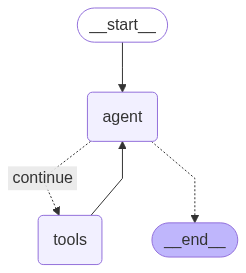

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [34]:
def print_stream(stream):
    """Helper function for formatting the stream nicely."""
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [HumanMessage(content="What's the weather like in Zurich, and what should I wear based on the temperature?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

What's the weather like in Zurich, and what should I wear based on the temperature?
================================== Ai Message ==================================
Tool Calls:
  search_tool (call_ABPcxdgsCELR1O0tNmVhTEEt)
 Call ID: call_ABPcxdgsCELR1O0tNmVhTEEt
  Args:
    query: current weather Zurich
================================= Tool Message =================================
Name: search_tool

[{"title": "Zurich, Zurich, Switzerland Weather Forecast | AccuWeather", "url": "https://www.accuweather.com/en/ch/zurich/316622/weather-forecast/316622", "content": "Tomorrow: Mostly sunny and pleasantly warm\nHi: 76\u00b0\n\n## Current Weather\n\n11:03 PM\n\n## Looking Ahead\n\nPleasant Sunday\n\n## Zurich Weather Radar\n\nZurich Weather Radar\n\n## Hourly Weather\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n\nrain drop\n